In [1]:
import networkx as nx
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../network/ia-escorts-dynamic.edges', sep=' ', skiprows=2, names= ["BuyerID", "SellerID", "Review", "Time"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50632 entries, 0 to 50631
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   BuyerID   50632 non-null  int64
 1   SellerID  50632 non-null  int64
 2   Review    50632 non-null  int64
 3   Time      50632 non-null  int64
dtypes: int64(4)
memory usage: 1.5 MB


In [3]:
df['Time'] = df['Time'].apply(lambda x: datetime.fromtimestamp(x))
df['Time'][:10]

0   2002-08-31 23:00:00
1   2002-08-31 23:00:00
2   2002-08-31 23:00:00
3   2002-09-21 23:00:00
4   2002-10-17 23:00:00
5   2002-11-12 22:00:00
6   2002-12-14 22:00:00
7   2002-12-30 22:00:00
8   2003-01-02 22:00:00
9   2003-01-04 22:00:00
Name: Time, dtype: datetime64[ns]

In [4]:
df['Time'].apply(lambda x: x.strftime('%H:%M:%S')).unique()

array(['23:00:00', '22:00:00'], dtype=object)

In [5]:
df = df.sort_values(by='Time')
df.head()

,BuyerID,SellerID,Review,Time
0,1,1,0,2002-08-31 23:00:00
1,1,2,1,2002-08-31 23:00:00
2,1,3,0,2002-08-31 23:00:00
3,2,1,0,2002-09-21 23:00:00
4,3,4,0,2002-10-17 23:00:00


In [6]:
print('min: ' + df['Time'].min().strftime('%d/%m/%Y'))
print('max: ' + df['Time'].max().strftime('%d/%m/%Y'))

min: 31/08/2002
max: 10/10/2008


In [7]:
# nodes, edges and rating
def get_nodes_and_edges_stats():
    '''
    Here we gather the statistics related to the nodes and edges of the network, summarized
    or counted every month.
    '''
    
    net = nx.MultiGraph(name="Companion Network")
    
    # absolute number of nodes
    n_nodes_dict = dict()
    # absolute number of edges
    n_edges_dict = dict()
    # absolute number of buyer nodes
    n_buyers_dict = dict()
    # absolute number of sellers nodes
    n_sellers_dict = dict()
    
    # total number of nodes that appear in an edge of every month
    n_active_users_dict = dict()

    # amount of new nodes in the network by each month
    new_nodes_dict = dict()
    # amount of new edges in the network by each month
    new_edges_dict = dict()
    
    # average rating by each month
    avg_rating_monthly_dict = dict()
    # rating ration over time
    rating_ratio_dict = dict()
    
    # monthly reset auxiliary variables
    active_users = []
    n_new_nodes = 0
    n_new_edges = 0
    rating_sum = 0
    n_rating = 0
    
    stop = datetime.strptime('01/01/2003', '%d/%m/%Y')
    for _, row in df.iterrows():
        # sumarrizes for every month
        if row['Time'] >= stop:
            key = stop - timedelta(days=1)
            
            n_nodes_dict[key] = len(net.nodes())
            n_edges_dict[key] = len(net.edges())
            n_buyers_dict[key] = len([n for n in net.nodes() if n.startswith('b')])
            n_sellers_dict[key] = len([n for n in net.nodes() if n.startswith('s')])
            
            n_active_users_dict[key] = len(set(active_users))
            active_users = []
            
            new_nodes_dict[key] = n_new_nodes
            new_edges_dict[key] = n_new_edges
            n_new_nodes = 0
            n_new_edges = 0
        
            rating_ratio_dict[key] = sum([data['review'] for _, _, data in net.edges.data()]) / len(net.edges())
            avg_rating_monthly_dict[key] = rating_sum / n_rating
            rating_sum = 0
            n_rating = 0
            
            if stop.month == 12:
                stop = datetime(year=stop.year+1, month=1, day=1)
            else:
                stop = datetime(year=stop.year, month=stop.month+1, day=1)
            
        n_new_edges += 1
    
        buyer_name = 'b' + str(row['BuyerID'])
        seller_name = 's' + str(row['SellerID'])
        
        if not buyer_name in net:
            n_new_nodes += 1
        if not seller_name in net:
            n_new_nodes += 1
        
        net.add_edge(buyer_name, seller_name, review=row['Review'], time=row['Time'])
            
        active_users.append(buyer_name)
        active_users.append(seller_name)
    
        rating_sum += row['Review']
        n_rating += 1
    
    # final summary
    key = row['Time'] - timedelta(days=1)    

    n_nodes_dict[key] = len(net.nodes())
    n_edges_dict[key] = len(net.edges())
    
    n_buyers_dict[key] = len([n for n in net.nodes() if n.startswith('b')])
    n_sellers_dict[key] = len([n for n in net.nodes() if n.startswith('s')])
    
    # to return
    stats = dict()
    stats['n_nodes'] = n_nodes_dict
    stats['n_edges'] = n_edges_dict
    stats['n_buyers'] = n_buyers_dict
    stats['n_sellers'] = n_sellers_dict
    stats['n_active_users'] = n_active_users_dict
    stats['new_nodes'] = new_nodes_dict
    stats['new_edges'] = new_edges_dict
    stats['rating_ratio'] = rating_ratio_dict
    stats['avg_rating_monthly'] = avg_rating_monthly_dict
    
    return stats

stats = get_nodes_and_edges_stats()

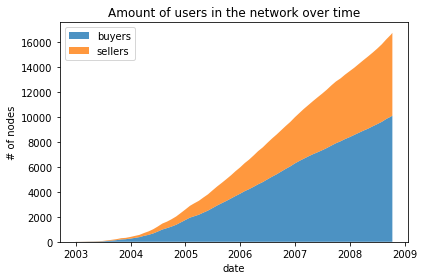

In [8]:
def plot_stacked_n_nodes(n_buyers_dict, n_sellers_dict):
    dates = n_buyers_dict.keys()

    n_by_type = dict()
    n_by_type['buyers'] = [v for _, v in n_buyers_dict.items()]
    n_by_type['sellers'] = [v for _, v in n_sellers_dict.items()]

    fig, ax = plt.subplots()
    ax.stackplot(dates, n_by_type.values(),
                labels=n_by_type.keys(), alpha=0.8)
    ax.set_title('Amount of users in the network over time')
    ax.set_xlabel('date')
    ax.set_ylabel('# of nodes')
    ax.legend(loc='upper left')

    plt.tight_layout()
    plt.savefig('../plots/stacked_n_nodes_over_time.png')
    plt.show()
    
plot_stacked_n_nodes(stats['n_buyers'], stats['n_sellers'])

In [36]:
def plot_line_graph(stats, title, xlabel, ylabel, file_name, log_y=False, invert_y=False, marker=False):
    if type(stats) == list:
        for s, label in stats:
            x1 = list(s.keys())
            x2 = [v for _, v in s.items()]
            plt.plot(x1, x2, label=label, marker='o' if marker else None)
        plt.legend()
    else:
        x1 = list(stats.keys())
        x2 = [v for _, v in stats.items()]
        plt.plot(x1, x2, marker='o' if marker else None)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if log_y:
        plt.yscale('log')
        
    if invert_y:
        plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.savefig(f'../plots/{file_name}.png')
    plt.show()

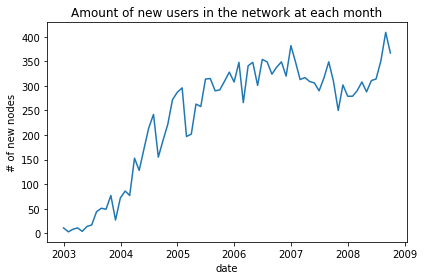

In [10]:
plot_line_graph(
    stats=stats['new_nodes'], 
    title='Amount of new users in the network at each month',
    xlabel='date',
    ylabel='# of new nodes',
    file_name='monthly_new_nodes'
)

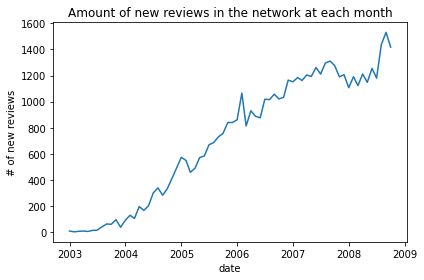

In [11]:
plot_line_graph(
    stats=stats['new_edges'],
    title='Amount of new reviews in the network at each month',
    xlabel='date',
    ylabel='# of new reviews',
    file_name='monthly_new_edges'
)

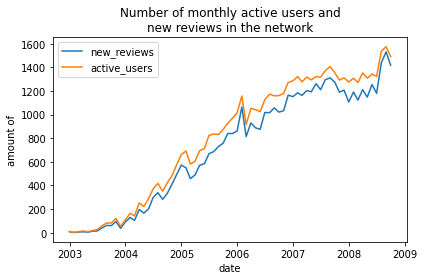

In [12]:
plot_line_graph(
    stats=[(stats['new_edges'], 'new_reviews'), (stats['n_active_users'], 'active_users')],
    title='Number of monthly active users and\nnew reviews in the network',
    xlabel='date',
    ylabel='amount of',
    file_name='monthly_active_users_and_edges'
)

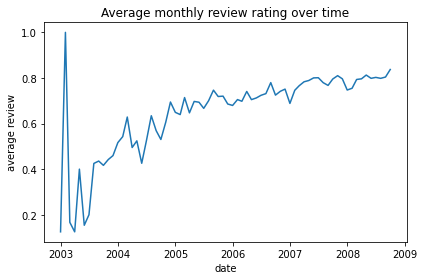

In [13]:
plot_line_graph(
    stats=stats['avg_rating_monthly'],
    title='Average monthly review rating over time',
    xlabel='date',
    ylabel='average review',
    file_name='avg_review_over_time'
)

In [14]:
# top users
def get_top_users_stats():
    '''
    Here we gather the statistics for the top users by certain criterias of every
    semester.
    '''
    
    net = nx.MultiGraph(name="Companion Network")

    # top overall buyers
    top_buyers_dict = dict()
    # top overall sellers
    top_sellers_dict = dict()

    # top buyers by each semester
    top_buyers_timely_dict = dict()
    # top sellers by each semester
    top_sellers_timely_dict = dict()
    
    # auxiliary variables, reset every semester
    top_sellers_semester_dict = dict()
    top_buyers_semester_dict = dict()

    stop = datetime.strptime('01/01/2003', '%d/%m/%Y')
    for _, row in df.iterrows():
        # summarizes for every semester
        if row['Time'] >= stop:
            key = stop - timedelta(days=1)
            
            buyers = [n for n in net.nodes() if n.startswith('b')]
            top_buyers_dict[key] = sorted([(n, net.degree(n)) for n in buyers], key=lambda x: x[1], reverse=True)

            sellers = [n for n in net.nodes() if n.startswith('s')]
            top_sellers_dict[key] = sorted([(n, net.degree(n)) for n in sellers], key=lambda x: x[1], reverse=True)
            
            top_buyers_timely_dict[key] = sorted([(name, n_reviews) for name, n_reviews in top_buyers_semester_dict.items()], key=lambda x: x[1], reverse=True)
            top_sellers_timely_dict[key] = sorted([(name, n_reviews) for name, n_reviews in top_sellers_semester_dict.items()], key=lambda x: x[1], reverse=True)
            
            top_buyers_semester_dict = dict()
            top_sellers_semester_dict = dict()
            
            if stop.month != 1:
                stop = datetime(year=stop.year+1, month=1, day=1)
            else:
                stop = datetime(year=stop.year, month=stop.month+6, day=1)
        
        buyer_name = 'b' + str(row['BuyerID'])
        seller_name = 's' + str(row['SellerID'])
        net.add_edge(buyer_name, seller_name, review=row['Review'], time=row['Time'])
        
        if buyer_name not in top_buyers_semester_dict.keys():
            top_buyers_semester_dict[buyer_name] = 1
        else:
            top_buyers_semester_dict[buyer_name] += 1
            
        if seller_name not in top_sellers_semester_dict.keys():
            top_sellers_semester_dict[seller_name] = 1
        else:
            top_sellers_semester_dict[seller_name] += 1
        
    # final summary
    key = stop - timedelta(days=1)   
            
    buyers = [n for n in net.nodes() if n.startswith('b')]
    top_buyers_dict[key] = sorted([(n, net.degree(n)) for n in buyers], key=lambda x: x[1], reverse=True)       
            
    sellers = [n for n in net.nodes() if n.startswith('s')]
    top_sellers_dict[key] = sorted([(n, net.degree(n)) for n in sellers], key=lambda x: x[1], reverse=True)

    top_buyers_timely_dict[key] = sorted([(name, n_reviews) for name, n_reviews in top_buyers_semester_dict.items()], key=lambda x: x[1], reverse=True)
    top_sellers_timely_dict[key] = sorted([(name, n_reviews) for name, n_reviews in top_sellers_semester_dict.items()], key=lambda x: x[1], reverse=True)
     
    # to return
    stats = dict()
    stats['top_buyers'] = top_buyers_dict
    stats['top_sellers'] = top_sellers_dict
    stats['top_buyers_timely'] = top_buyers_timely_dict
    stats['top_sellers_timely'] = top_sellers_timely_dict 
    
    return stats
                   
stats = get_top_users_stats()

In [15]:
def plot_top_users(stats, title, xlabel, ylabel, file_name, n_top=8):
    palette = [
        '#6929c4', '#1192e8', '#005d5d', '#9f1853',
        '#fa4d56', '#570408', '#198038', '#002d9c',
        '#ee538b', '#b28600', '#009d9a', '#012749',
        '#8a3800', '#a56eff'
    ]
    codes = []
    for _, v in list(stats.items())[1:]:
        codes.extend([x[0] for x in v[:n_top]])
    codes = set(codes)
    color_dict = dict()
    for i, c in enumerate(codes):
        color_dict[c] = palette[i % len(palette)]

    fig, axs = plt.subplots(6, 2, figsize=(10, 11), sharex=True)
    fig.suptitle(title, fontsize=16)

    for (key, top_s), ax in zip(list(stats.items())[1:], axs.flat):
        plt.sca(ax)
        ax.set_title(key.strftime('%b %Y'))
        
        x1, x2 = zip(*sorted(top_s[:n_top], key=lambda x: x[1]))
        plt.barh(x1, x2, color=[color_dict[s] for s in x1])
        
    for ax in axs.flat[::-1][:2]:
        ax.set_xlabel(xlabel)
        
    for i in range(0, 12, 2):
        axs.flat[i].set_ylabel(ylabel)
        
    plt.tight_layout()
    plt.rcParams['savefig.facecolor'] = 'white'
    plt.savefig(f'../plots/{file_name}.png')
    plt.show()

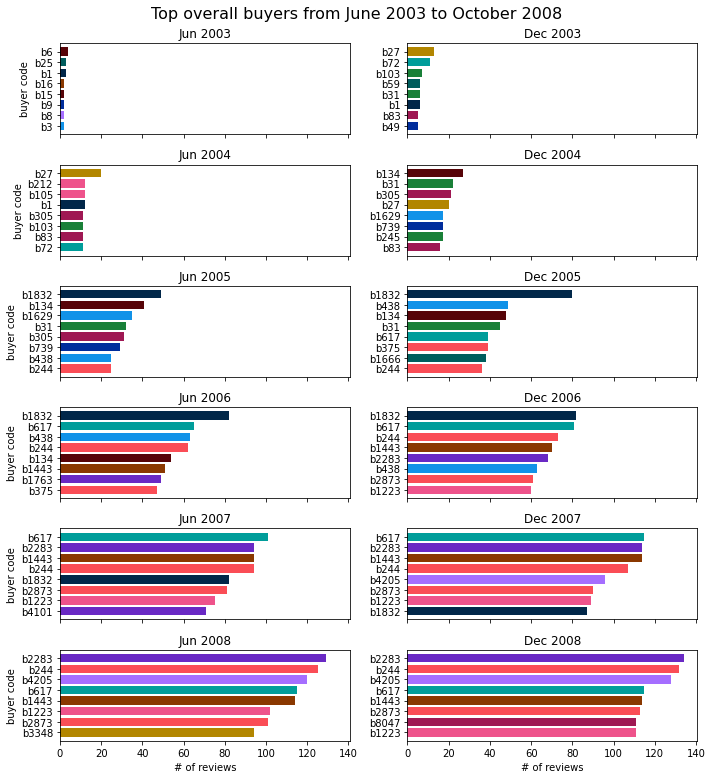

In [16]:
plot_top_users(
    stats=stats['top_buyers'],
    title='Top overall buyers from June 2003 to October 2008',
    xlabel='# of reviews',
    ylabel='buyer code',
    file_name='best_buyers'
)

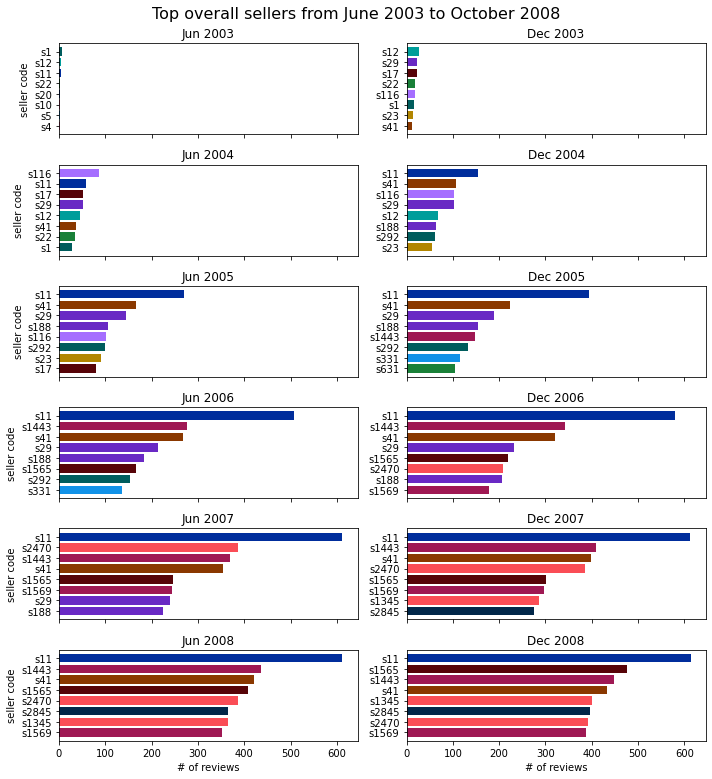

In [17]:
plot_top_users(
    stats=stats['top_sellers'],
    title='Top overall sellers from June 2003 to October 2008',
    xlabel='# of reviews',
    ylabel='seller code',
    file_name='best_sellers'
)

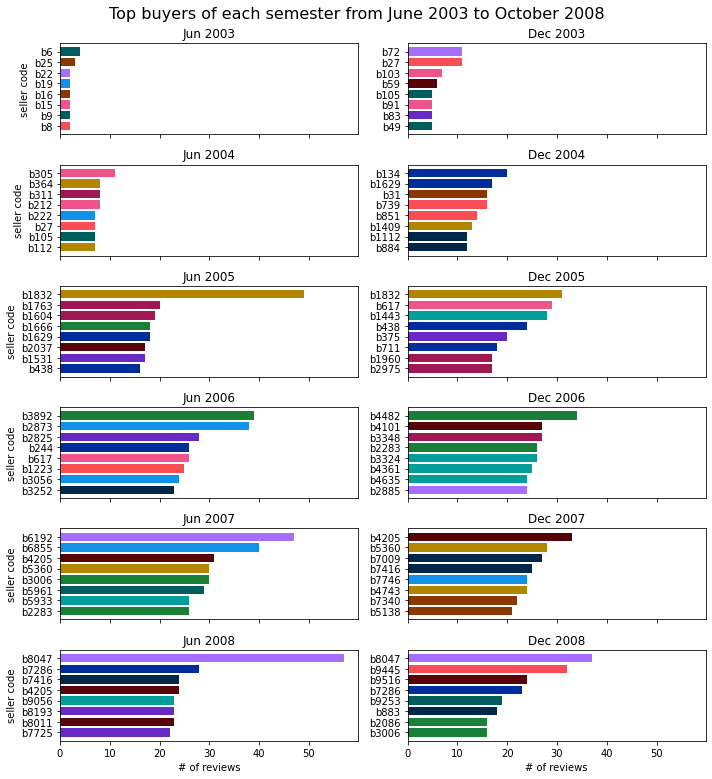

In [18]:
plot_top_users(
    stats=stats['top_buyers_timely'],
    title='Top buyers of each semester from June 2003 to October 2008',
    xlabel='# of reviews',
    ylabel='seller code',
    file_name='best_buyers_semester'
)

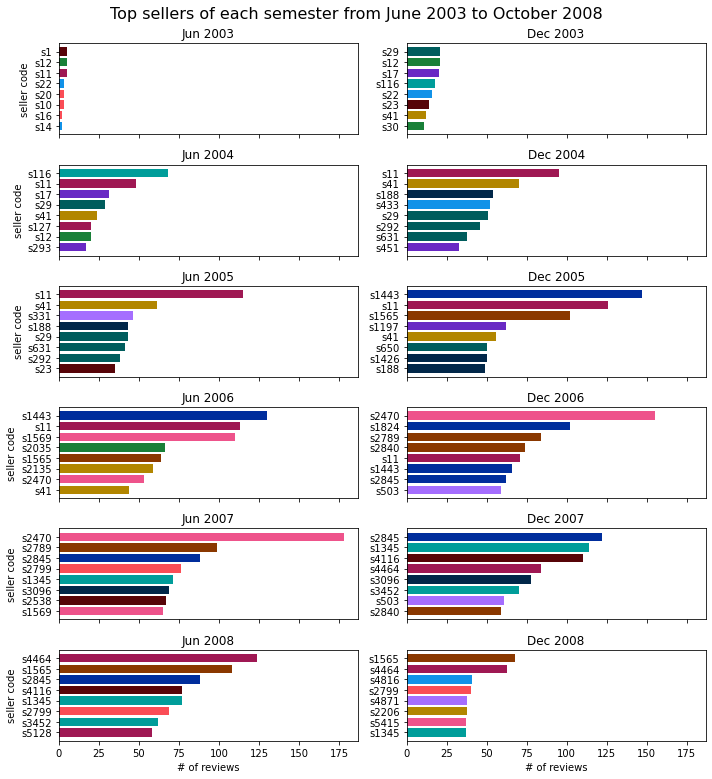

In [19]:
plot_top_users(
    stats=stats['top_sellers_timely'],
    title='Top sellers of each semester from June 2003 to October 2008',
    xlabel='# of reviews',
    ylabel='seller code',
    file_name='best_sellers_semester'
)

In [40]:
def plot_user_ranking(user_codes, stats, title, xlabel, ylabel, file_name):
    ranking = list()
    
    for uc in user_codes:
        ranking_pos_dict = dict()
        for key, v in stats.items():
            pos = None
            for i, (name, _) in enumerate(v):
                if name == uc:
                    pos = i + 1
                    break
            ranking_pos_dict[key] = pos
        ranking.append((ranking_pos_dict, uc,))
    
    plot_line_graph(
        stats=ranking,
        title=title, xlabel=xlabel, ylabel=ylabel, file_name=file_name, 
        log_y=True, invert_y=True
    )

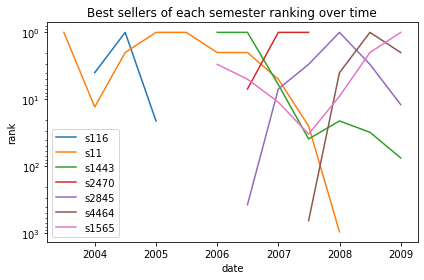

In [41]:
user_codes = ['s116', 's11', 's1443', 's2470', 's2845', 's4464', 's1565']
plot_user_ranking(
    user_codes=user_codes, stats=stats['top_sellers_timely'],
    title=f'Best sellers of each semester ranking over time',
    xlabel='date', ylabel='rank', file_name=f'sellers_rank'
)

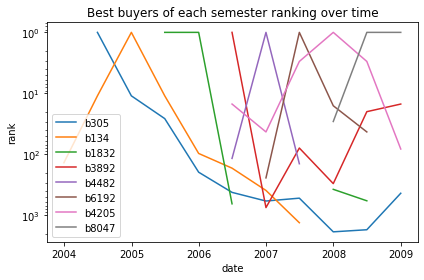

In [42]:
user_codes = ['b305', 'b134', 'b1832', 'b3892', 'b4482', 'b6192', 'b4205', 'b8047']
plot_user_ranking(
    user_codes=user_codes, stats=stats['top_buyers_timely'],
    title=f'Best buyers of each semester ranking over time',
    xlabel='date', ylabel='rank', file_name=f'buyers_rank'
)